# Grundlæggende regression: Forudsig brændstofeffektivitet

I et *regressions*-problem er målet at forudsige outputtet af en kontinuerlig værdi, som for eksempel en pris eller en sandsynlighed. Dette står i kontrast til et *klassifikations*-problem, hvor målet er at vælge en klasse fra en liste af klasser (for eksempel når et billede indeholder et æble eller en appelsin, at genkende hvilken frugt der er på billedet).

Denne vejledning bruger det klassiske [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) datasæt og demonstrerer, hvordan man bygger modeller til at forudsige brændstofeffektiviteten for biler fra slutningen af 1970'erne og begyndelsen af 1980'erne. For at gøre dette vil du forsyne modellerne med en beskrivelse af mange biler fra denne tidsperiode. Denne beskrivelse inkluderer attributter som cylindere, slagvolumen, hestekræfter og vægt.

Dette eksempel bruger Keras API'et. (I kan bruge Keras [vejledninger](https://www.tensorflow.org/tutorials/keras) og [guides](https://www.tensorflow.org/guide/keras) for at lære mere.)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Laver NumPy-printouts lettere at læse.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.18.0


## "The Auto MPG" datasæt

# Datasættet er tilgængeligt fra [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Hent dataene
Først download og importer datasættet ved hjælp af pandas:

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Rens dataene

Datasættet indeholder et par ukendte værdier:

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Fjern rækker med ukendte værdier:


In [7]:
dataset = dataset.dropna()

Kolonnen `"Origin"` er kategorisk, ikke numerisk. Så det næste skridt er at one-hot encode værdierne i kolonnen med [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

Man kan læse mere om one-hot encoding her: [ml-one-hot-encoding](https://www.geeksforgeeks.org/ml-one-hot-encoding/)


In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


### Del dataene op i trænings- og test-sæt

Nu skal datasættet opdeles i et træningssæt og et test-sæt. Du vil bruge test-sættet i den endelige evaluering af dine modeller.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspicer dataene

Gennemgå den fælles fordeling af et par kolonnepar fra træningssættet.

Den øverste række antyder, at brændstofeffektiviteten (MPG) er en funktion af alle de andre parametre. De andre rækker indikerer, at de er funktioner af hinanden.

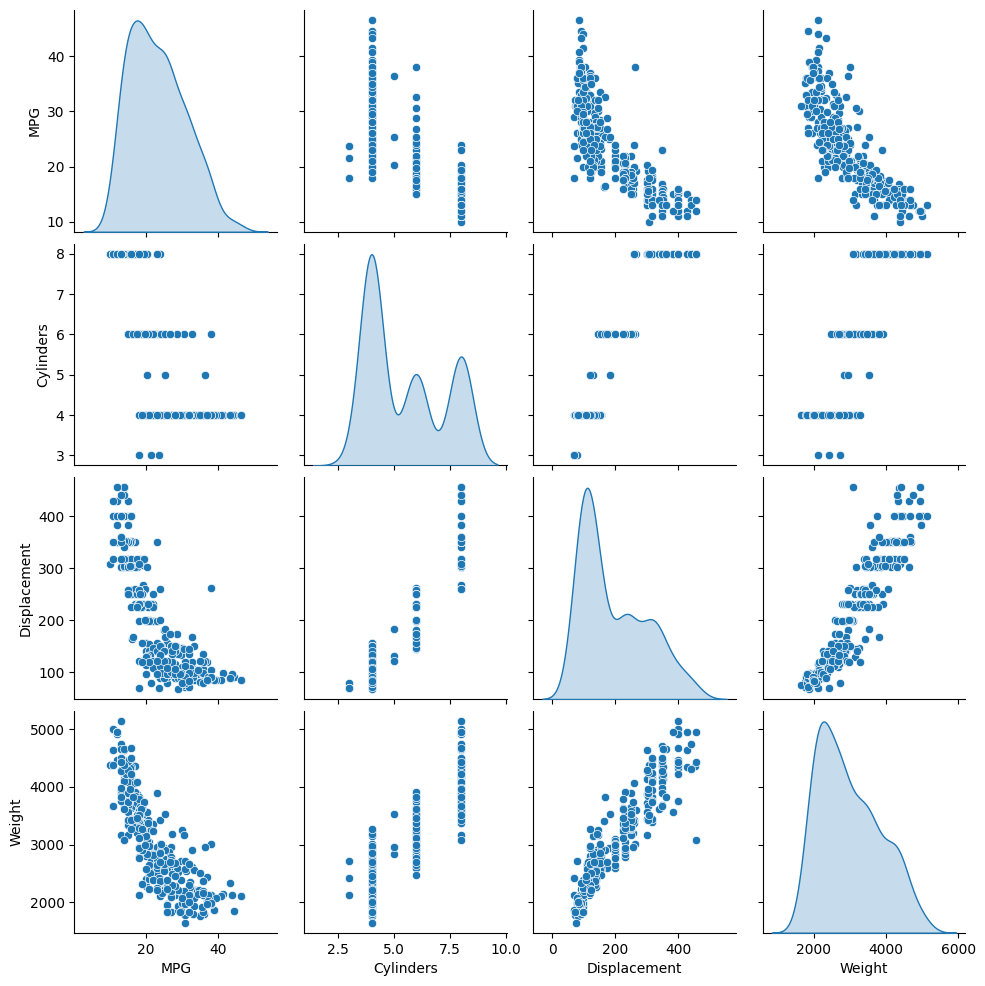

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Lad os også kontrollere de overordnede statistikker. Bemærk, hvordan hver funktion dækker et meget anderledes område:

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


### Opdel funktioner fra mærker

Separér målvariablen—mærket—fra funktionerne. Denne mærke er den værdi, du vil træne modellen til at forudsige.


In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization

I tabellen med statistikker er det let at se, hvor meget forskellige funktionerne er: 


In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


Det er en god praksis at normalisere funktioner, der bruger forskellige skalaer og områder. 

En grund til, at dette er vigtigt, er, at funktionerne ganges med modellens vægte. Så påvirkes skalaen af output og gradienten af skalaen af input.

Selvom en model *muligvis* kan konvergere uden funktionsnormalisering, gør normalisering træning meget mere stabil. 


### Normalisering lag

`tf.keras.layers.Normalization` er en ren og simpel måde at tilføje funktionsnormalisering til vores model. 

Første trin er at oprette laget:


In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Derefter passer vi tilstanden af forbehandlingslaget til data ved at kalde `Normalization.adapt`:

In [16]:
normalizer.adapt(np.array(train_features))


Vi beregner gennemsnittet og variansen, og gemmer dem i laget:

In [17]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


Når laget kaldes, returnerer det inputdataen, med hver funktion normaliseret uafhængigt:

In [22]:
first = np.array(train_features[:1]).astype('float32')

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression | Lineær regression

Før vi bygger en neural network model, starter vi med lineær regression ved hjælp af en og flere variable.

### Linear regression med én variabel

Begynd med en enkeltvariabel lineær regression for at forudsige `'MPG'` fra `'Horsepower'`.

At træne en model med `tf.keras` starter typisk med at definere modelarkitekturen. Brug en `tf.keras.Sequential` model, som [repræsenterer en sekvens af trin](https://www.tensorflow.org/guide/keras/sequential_model).

Der er to trin i din enkeltvariabel lineære regressionsmodel:

- Normaliser inputfunktionerne `'Horsepower'` ved hjælp af `tf.keras.layers.Normalization` preprocessing-laget.
- Anvend en lineær transformation ($y = mx+b$) for at producere 1 output ved hjælp af et lineært lag (`tf.keras.layers.Dense`).

Antallet af _inputs_ kan enten sættes ved `input_shape` argumentet eller automatisk, når modellen køres første gang.

Først, lav en NumPy array, der består af funktionen `'Horsepower'`. Så opretter vi `tf.keras.layers.Normalization` laget og passer tilstanden af laget til data:


In [23]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

c:\Users\phpa.skp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Byg Keras Sequential model:

In [24]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

Denne model vil forudsige `'MPG'` fra `'Horsepower'`.

Kør den ubegyndelige model på de første 10 'Horsepower' værdier. Outputtet vil ikke være godt, men bemærk, at det har den forventede form af `(10, 1)`:



In [25]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


array([[-0.876],
       [-0.495],
       [ 1.617],
       [-1.228],
       [-1.111],
       [-0.436],
       [-1.316],
       [-1.111],
       [-0.289],
       [-0.495]], dtype=float32)

Når vi bygger modellen, konfigurerer vi træningen ved hjælp af `tf.keras.Model.compile` metode. De vigtigste argumenter at konfigurere er `loss` og `optimizer`, da disse definerer, hvad der vil blive optimalt (`mean_absolute_error`) og hvordan (ved hjælp af `tf.keras.optimizers.Adam`).


In [26]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Brug Keras `Model.fit` til at udføre træningen for 100 epoker:


In [27]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 23.8 s
Wall time: 24.4 s


Visualiser modellens træningsprogres ved hjælp af stats gemt i `history` objektet:


In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804692,4.178810,95
96,3.803521,4.203298,96
97,3.803199,4.196061,97
98,3.804716,4.169964,98
99,3.807186,4.164002,99


In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

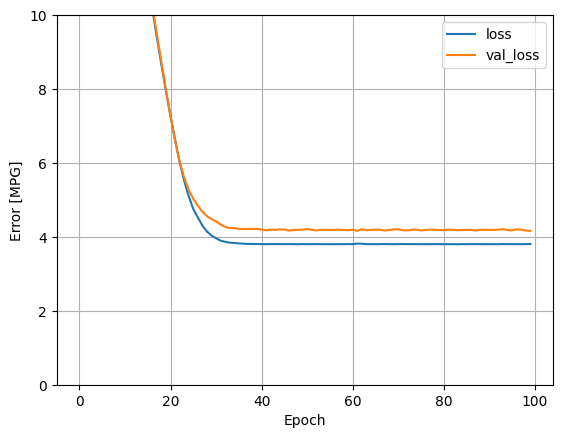

In [30]:
plot_loss(history)

Indsamle resultaterne på test-sættet for senere:

In [31]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Siden dette er en enkeltvariabel regression, er det let at se modellens forudsagelser som en funktion af input:

In [32]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [33]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

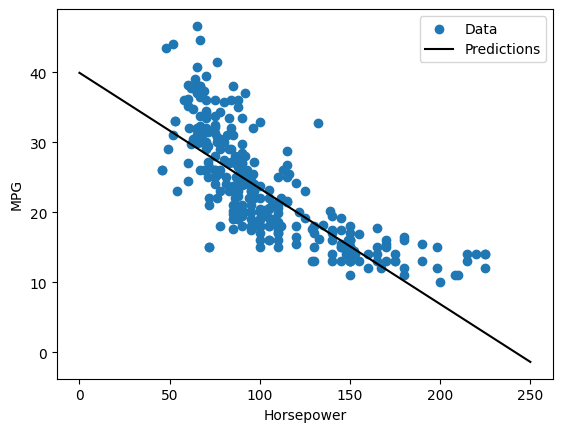

In [34]:
plot_horsepower(x, y)

### Lineær regression med flere inputs

Du kan bruge en næsten identisk opsætning til at forudsige baseret på flere inputs. Denne model gør det samme $y = mx+b$, men $m$ er en matrix og $b$ er en vektor. 

Opret en to-trin Keras Sequential model igen med det første lag som `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) du definerede tidligere og tilpasset hele datasættet:


In [35]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

Når du kalder `Model.predict` på en batch af inputs, producerer det `units=1` outputs for hver eksempel:

In [36]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


array([[ 0.696],
       [ 0.396],
       [-0.336],
       [ 0.15 ],
       [-1.663],
       [-0.252],
       [-1.639],
       [ 1.073],
       [-0.004],
       [-1.042]], dtype=float32)

Når du kalder modellen, vil dens vægtmatricer blive bygget—sørg for, at `kernel` vægte (den $m$ i $y=mx+b$) har en form af `(9, 1)`: 

In [37]:
linear_model.layers[1].kernel

<Variable path=sequential_1/dense_1/kernel, shape=(9, 1), dtype=float32, value=[[-0.595]
 [ 0.177]
 [ 0.523]
 [-0.469]
 [ 0.122]
 [-0.19 ]
 [ 0.735]
 [-0.471]
 [ 0.44 ]]>

Konfigurer modellen med Keras `Model.compile` og træn med `Model.fit` for 100 epoker: 

In [38]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [39]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 20.3 s
Wall time: 20 s


Denne model opnår en meget lavere trænings- og valideringsfejl end `horsepower_model`, som havde en input:

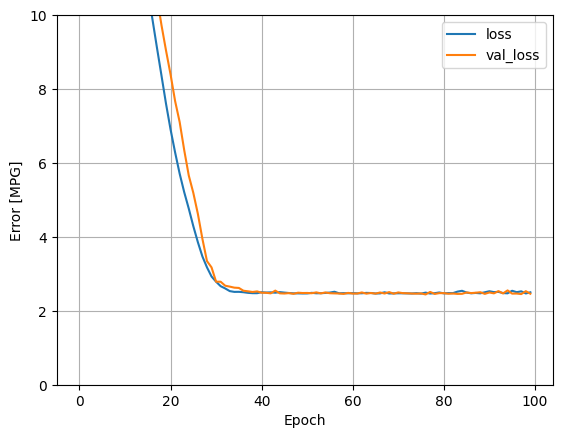

In [40]:
plot_loss(history)

Indsamle resultaterne på test-sættet for senere:

In [41]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression med en Deep Neural Network (DNN) 

I den forrige sektion, implementerede du to lineære modeller for enkelt- og fler-input. 

Her implementerer du enkelt- og fler-input DNN modeller.

Koden er næsten den samme, undtagen at modellen udvides til at inkludere nogle "skjulte" ikke-lineære lag. Navnet "skjult" her betyder, at det ikke er direkte forbundet med input eller output.

Disse modeller vil indeholde et par flere lag end lineære modeller: 

* Normaliseringslaget, som før (med `horsepower_normalizer` for enkelt-input model og `normalizer` for fler-input model). 
* To skjulte, ikke-lineære, `Dense` lag med ReLU (`relu`) aktiveringsfunktionen.
* En lineær `Dense` outputlag.

Begge modeller vil bruge den samme træningsprocedure, så `compile` metode er inkluderet i `build_and_compile_model` funktionen nedenfor.


In [42]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression med en DNN og et enkelt input

Opret en DNN model med kun `'Horsepower'` som input og `horsepower_normalizer` (defineret tidligere) som normaliseringslag:

In [43]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

Denne model har et par flere trænbare parametre end lineære modeller:

In [44]:
dnn_horsepower_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Træn modellen med Keras `Model.fit`:

In [45]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 24 s
Wall time: 24.8 s


Denne model gør lidt bedre end lineære enkelt-input `horsepower_model`:

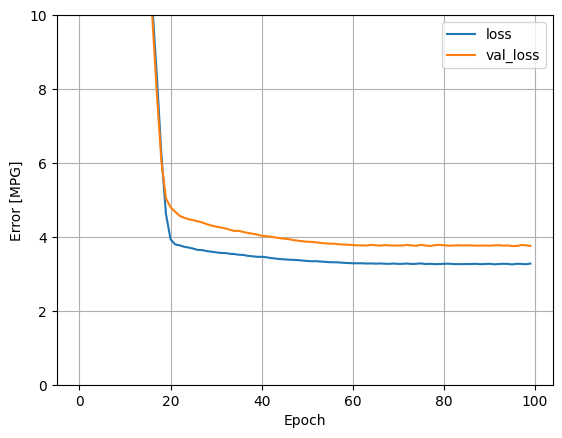

In [46]:
plot_loss(history)

Hvis du plotter forudsagelserne som en funktion af `'Horsepower'`, bør du bemærke, hvordan denne model udnytter den ikke-lineære natur af skjulte lag: 

In [47]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E57B247920> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


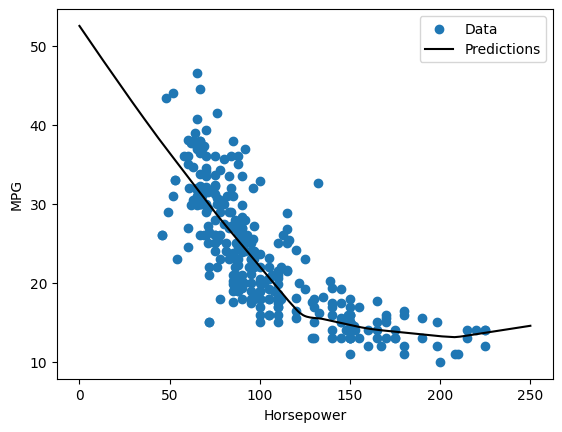

In [48]:
plot_horsepower(x, y)

Indsamle resultaterne på test-sættet for senere:

In [49]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression med en DNN og flere inputs

Gentag den tidligere proces ved hjælp af alle input. Modellens ydeevne forbedres lidt på valideringsdatasættet.

In [50]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [51]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 23.4 s
Wall time: 25.9 s


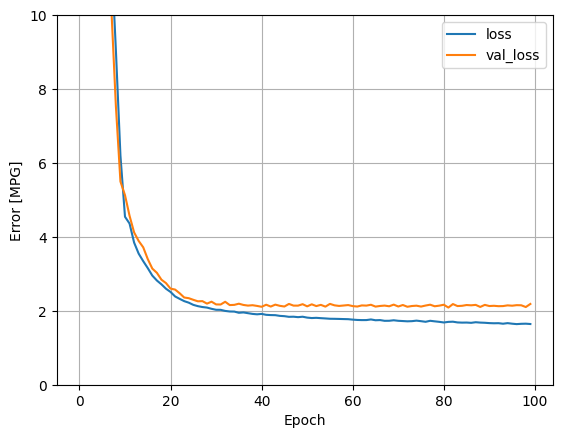

In [52]:
plot_loss(history)

Indsamle resultaterne på test-sættet:

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Ydeevne

Da alle modeller er trænet, kan du gennemgå deres ydeevne på test-sættet:

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.649950
linear_model,2.464466
dnn_horsepower_model,2.898401
dnn_model,1.732547


Disse resultater matcher den valideringsfejl, der blev observeret under træning. 

### Lav forudsagelser

Du kan nu lave forudsagelser med `dnn_model` på test-sættet ved hjælp af Keras `Model.predict` og gennemgå tabet:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


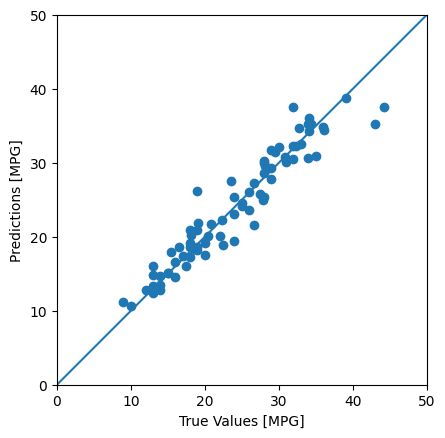

In [55]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Det ser ud til, at modellen forudsiger rimeligt godt.

Nu, kontroller fejldistributionen:

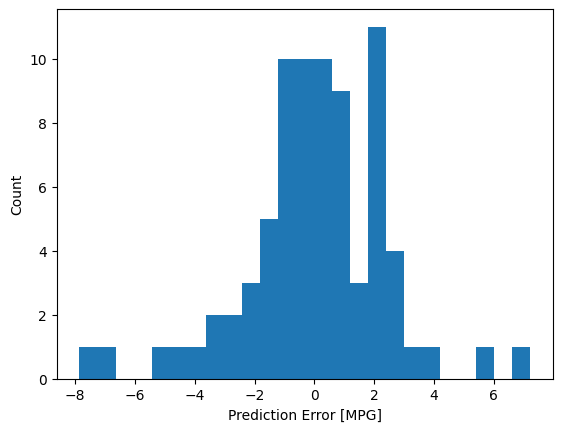

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

Hvis du er tilfreds med modellen, gem den til senere brug med `Model.save`: 

In [58]:
dnn_model.save('dnn_model.keras')

Hvis du genindlæser modellen, giver den identiske output: 

In [60]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [61]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.649950
linear_model,2.464466
dnn_horsepower_model,2.898401
dnn_model,1.732547
reloaded,1.732547


## Konklusion

Denne vejledning introducerede et par teknikker til at håndtere et regressionsproblem. Her er et par flere tips, der kan hjælpe: Specielt til jeres projekt i uge nummer 2!


- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) og mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) er almindelige loss funktioner, der bruges til regressionsproblemer. MAE er mindre følsom over for outliers. Forskellige loss funktioner bruges til klassifikationsproblemer. 
- Ligeledes bruges evalueringsmetrikkerne for regressionsproblemer fra klassifikationsproblemer.
- Når numeriske input data features har værdier med forskellige ranges, bør hver feature skaleres uafhængigt til den samme range.
- Overfitting er et almindeligt problem for DNN modeller, selvom det ikke var et problem i denne vejledning. Besøg [Overfit og underfit](../4.Fit/) vejledningen for yderligere hjælp.